[![Open In Colab](https://colab.research.google.com/assets/colab-badge.svg)](https://colab.research.google.com/github/Jarvis-Geun/DeepLearning-Wiki/blob/main/Generative-Model/GAN.ipynb)

### Reference
- [나동빈님 Github](https://github.com/ndb796/Deep-Learning-Paper-Review-and-Practice/blob/master/code_practices/GAN_for_MNIST_Tutorial.ipynb)  
GAN for MNIST Tutorial
- [최윤제님 Github](https://github.com/yunjey/pytorch-tutorial/blob/master/tutorials/03-advanced/generative_adversarial_network/main.py#L42)  
pytorch-tutorial/tutorials/03-advanced/generative_adversarial_network/main.py

If you only want to check results of test, jump to `6. Test the model` and just download the `Generator.ckpt` file with below code.

테스트 결과만 확인하고 싶다면, 먼저 바로 아래의 코드 `!wget`을 실행시킨 후에 `6. Test the model`로 가서 코드를 실행시키면 됩니다.

In [1]:
!wget https://github.com/Jarvis-Geun/Pytorch-wiki/raw/main/GAN/Generator.ckpt

--2022-04-12 13:43:25--  https://github.com/Jarvis-Geun/Pytorch-wiki/raw/main/GAN/Generator.ckpt
Resolving github.com (github.com)... 52.78.231.108
Connecting to github.com (github.com)|52.78.231.108|:443... connected.
HTTP request sent, awaiting response... 302 Found
Location: https://raw.githubusercontent.com/Jarvis-Geun/Pytorch-wiki/main/GAN/Generator.ckpt [following]
--2022-04-12 13:43:26--  https://raw.githubusercontent.com/Jarvis-Geun/Pytorch-wiki/main/GAN/Generator.ckpt
Resolving raw.githubusercontent.com (raw.githubusercontent.com)... 185.199.108.133, 185.199.109.133, 185.199.110.133, ...
Connecting to raw.githubusercontent.com (raw.githubusercontent.com)|185.199.108.133|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 991767 (969K) [application/octet-stream]
Saving to: ‘Generator.ckpt.1’

Generator.ckpt.1    100%[===================>] 968.52K  --.-KB/s    in 0.09s   

2022-04-12 13:43:26 (10.7 MB/s) - ‘Generator.ckpt.1’ saved [991767/991767]



## 1. Import Libraries

In [1]:
import torch
import torch.nn as nn
from torchvision import datasets    # To load MNIST dataset, import datasets
from torchvision.utils import save_image
import torchvision.transforms as transforms
from tqdm import tqdm

`-` save_image
- [save_image](https://pytorch.org/vision/stable/generated/torchvision.utils.save_image.html#torchvision.utils.save_image) : Save a given Tensor into an image file

## 2. System Setting and Hyperparameters

In [2]:
# Check cuda configuration
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

In [3]:
# Hyperparameters
latent_dim = 100    # latent vector
image_size = 28*28   # 28 x 28 = 784
num_epochs = 200
lr = 0.0002
mean = [0.5]
std = [0.5]
# batch_size = 100

## 3. Define Discriminator and Generator

- [nn.LeakyReLU(negative_slope=0.1, inplace=False)](https://pytorch.org/docs/stable/generated/torch.nn.LeakyReLU.html)
- [(image) LeakyReLU activation function](https://pytorch.org/docs/stable/_images/LeakyReLU.png)

### 3.1 Define Discriminator class

In [4]:
class discriminator(nn.Module):
    def __init__(self):
        super(discriminator, self).__init__()

        self.model = nn.Sequential(
            nn.Linear(image_size, 512),
            nn.LeakyReLU(0.2),
            nn.Linear(512, 256),
            nn.LeakyReLU(0.2),
            nn.Linear(256, 1),
            nn.Sigmoid()
        )

    def forward(self, image):
        # reshape image to one dimension (flattened)
        image_input = image.reshape(image.size(0), -1)
        output = self.model(image_input)
        return output

### 3.2 Define Generator class

In [5]:
class generator(nn.Module):
    def __init__(self):
        super(generator, self).__init__()

        self.model = nn.Sequential(
            nn.Linear(latent_dim, 128),
            nn.LeakyReLU(0.2),
            nn.Linear(128, 256),
            nn.LeakyReLU(0.2),
            nn.Linear(256, image_size),
            nn.Tanh()
        )

    def forward(self, z):
        image_output = self.model(z)
        input = image_output.reshape(image_output.size(0), 1, 28, 28)
        return input

## 4. Load data (MNIST)

### 4.1 Define Transform

`-` transforms.Normalize() ➡️ right_arrow Standardization
- output[channel] = (input[channel] - mean[channel]) / std[channel]
- [Normalization, Standardization, ...](https://realblack0.github.io/2020/03/29/normalization-standardization-regularization.html)

`-` Denormalize  
- [Denormalize_1](https://github.com/pytorch/vision/issues/848)
- [Denormalize_2](https://discuss.pytorch.org/t/issue-with-using-dataparallel-runtimeerror-output-0-of-broadcastbackward-is-a-view-and-its-base-or-another-view-of-its-base-has-been-modified-inplace/84677)
- $X' = \frac{X\ -\  \mu}{\sigma}$ ➡️ $X = X'\sigma\ +\ \mu$

In [6]:
transform = transforms.Compose([
    transforms.ToTensor(),
    transforms.Normalize(mean=mean, std=std) # Since MNIST is graycale, just using 1 channel
])

def denormalize(x):
    out = (x + 1) / 2
    return out.clamp(0, 1)

### 4.2 Load MNIST dataset

In [7]:
MNIST_dataset = datasets.MNIST(root="./MNIST_dir",
    train=True,
    transform=transform,
    download=True)

### 4.3 Define Dataloader

In [8]:
dataloader = torch.utils.data.DataLoader(MNIST_dataset,
    batch_size=128,
    shuffle=True)

## 5. Train the model

### 5.1 Cuda setting

In [9]:
Discriminator = discriminator()
Generator = generator()

Discriminator.cuda()
Generator.cuda()

generator(
  (model): Sequential(
    (0): Linear(in_features=100, out_features=128, bias=True)
    (1): LeakyReLU(negative_slope=0.2)
    (2): Linear(in_features=128, out_features=256, bias=True)
    (3): LeakyReLU(negative_slope=0.2)
    (4): Linear(in_features=256, out_features=784, bias=True)
    (5): Tanh()
  )
)

In [10]:
print(Discriminator, end="\n")
print(Generator, end="\n")

discriminator(
  (model): Sequential(
    (0): Linear(in_features=784, out_features=512, bias=True)
    (1): LeakyReLU(negative_slope=0.2)
    (2): Linear(in_features=512, out_features=256, bias=True)
    (3): LeakyReLU(negative_slope=0.2)
    (4): Linear(in_features=256, out_features=1, bias=True)
    (5): Sigmoid()
  )
)
generator(
  (model): Sequential(
    (0): Linear(in_features=100, out_features=128, bias=True)
    (1): LeakyReLU(negative_slope=0.2)
    (2): Linear(in_features=128, out_features=256, bias=True)
    (3): LeakyReLU(negative_slope=0.2)
    (4): Linear(in_features=256, out_features=784, bias=True)
    (5): Tanh()
  )
)


### 5.2 Define Loss function

In [11]:
criterion = nn.BCELoss()
# criterion.cuda()

### 5.3 Define Optimizer

In [12]:
D_optimizer = torch.optim.Adam(Discriminator.parameters(),
    lr=lr,
    betas=(0.5, 0.999))

G_optimizer = torch.optim.Adam(Generator.parameters(),
    lr=lr,
    betas=(0.5, 0.999))

### 5.4 Train the model

In [13]:
# for epoch in tqdm(range(num_epochs)):
for epoch in range(num_epochs):
    for i, (images, _) in enumerate(dataloader):
        real_images = images.to(device)

        # Create real labels and fake labels
        real_labels = torch.cuda.FloatTensor(images.size(0), 1).fill_(1.0)
        # real_labels = torch.ones(images.size(0), 1)
        fake_labels = torch.cuda.FloatTensor(images.size(0), 1).fill_(0.0)
        # fake_labels = torch.zeros(images.size(0), 1)


        ################# Train the Discriminator #################
        
        ## Real loss of Discriminator ##
        d_real_output = Discriminator(real_images)
        d_real_loss = criterion(d_real_output, real_labels)

        ## Fake loss of Discriminator ##
        z = torch.randn(real_images.size(0), latent_dim).to(device)
        g_fake_output = Generator(z)
        d_g_fake_output = Discriminator(g_fake_output)
        d_fake_loss = criterion(d_g_fake_output, fake_labels)

        ## Total loss of Discriminator ##
        d_total_loss = d_real_loss + d_fake_loss

        ## Update Discriminator for backpropagation and Optimizer ##
        D_optimizer.zero_grad()
        d_total_loss.backward()
        D_optimizer.step()


        ################# Train the Generator #################
        g_fake_output = Generator(z)
        g_fake_loss = criterion(Discriminator(g_fake_output), real_labels)
        G_optimizer.zero_grad()
        g_fake_loss.backward()
        G_optimizer.step()

    # Print log per one epoch
    print("Epoch [{}/{}]  d_total_loss {:.4f}  g_fake_loss {:.4f}"
        .format(epoch, num_epochs, d_total_loss.item(), g_fake_loss.item()))

    # Save real images
    if (epoch+1) == 1:
        real_images = real_images.reshape(real_images.size(0), 1, 28, 28)
        save_image(denormalize(real_images).data[:100], "real-image_{}.png".format(epoch+1), nrow=10)

    # Save fake images
    fake_images = g_fake_output.reshape(g_fake_output.size(0), 1, 28, 28)
    save_image(denormalize(fake_images).data[:100], "fake-image_{}.png".format(epoch+1), nrow=10, normalize=False)

# Save the model checkpoints
torch.save(Discriminator.state_dict(), "Discriminator.ckpt")
torch.save(Generator.state_dict(), "Generator.ckpt")

Epoch [0/200]  d_total_loss 0.1982  g_fake_loss 3.6464
Epoch [1/200]  d_total_loss 0.5632  g_fake_loss 4.0442
Epoch [2/200]  d_total_loss 0.2325  g_fake_loss 3.4393
Epoch [3/200]  d_total_loss 0.2285  g_fake_loss 1.3144
Epoch [4/200]  d_total_loss 0.7820  g_fake_loss 6.3295
Epoch [5/200]  d_total_loss 0.3884  g_fake_loss 1.4747
Epoch [6/200]  d_total_loss 0.3206  g_fake_loss 2.3737
Epoch [7/200]  d_total_loss 0.3504  g_fake_loss 2.6543
Epoch [8/200]  d_total_loss 0.7078  g_fake_loss 6.2611
Epoch [9/200]  d_total_loss 0.4590  g_fake_loss 1.5432
Epoch [10/200]  d_total_loss 1.2903  g_fake_loss 1.8122
Epoch [11/200]  d_total_loss 1.1547  g_fake_loss 8.3247
Epoch [12/200]  d_total_loss 0.4427  g_fake_loss 3.7032
Epoch [13/200]  d_total_loss 0.3775  g_fake_loss 2.0408
Epoch [14/200]  d_total_loss 0.5688  g_fake_loss 1.6185
Epoch [15/200]  d_total_loss 0.6020  g_fake_loss 1.3567
Epoch [16/200]  d_total_loss 0.5986  g_fake_loss 3.2114
Epoch [17/200]  d_total_loss 0.6567  g_fake_loss 2.5583
Ep

## 6. Test the model

In [9]:
import torch
import torch.nn as nn
from torchvision import datasets    # To load MNIST dataset, import datasets
from torchvision.utils import save_image
import torchvision.transforms as transforms

In [10]:
# Check cuda configuration
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

In [11]:
# Hyperparameters
latent_dim = 100    # latent vector
image_size = 28*28   # 28 x 28 = 784
num_epochs = 200
lr = 0.0002
mean = [0.5]
std = [0.5]

In [12]:
class generator(nn.Module):
    def __init__(self):
        super(generator, self).__init__()

        self.model = nn.Sequential(
            nn.Linear(latent_dim, 128),
            nn.LeakyReLU(0.2),
            nn.Linear(128, 256),
            nn.LeakyReLU(0.2),
            nn.Linear(256, image_size),
            nn.Tanh()
        )

    def forward(self, z):
        image_output = self.model(z)
        input = image_output.reshape(image_output.size(0), 1, 28, 28)
        return input

In [13]:
def denormalize(x):
    out = (x + 1) / 2
    return out.clamp(0, 1)

In [14]:
model_gener = generator().to(device)
model_gener.load_state_dict(torch.load("Generator.ckpt"))

model_gener.eval()

generator(
  (model): Sequential(
    (0): Linear(in_features=100, out_features=128, bias=True)
    (1): LeakyReLU(negative_slope=0.2)
    (2): Linear(in_features=128, out_features=256, bias=True)
    (3): LeakyReLU(negative_slope=0.2)
    (4): Linear(in_features=256, out_features=784, bias=True)
    (5): Tanh()
  )
)

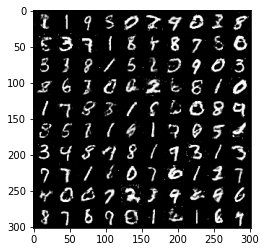

In [31]:
import matplotlib.pyplot as plt

z = torch.randn(100, latent_dim).to(device)
g_fake_output = model_gener(z)
fake_images = g_fake_output.reshape(g_fake_output.size(0), 1, 28, 28)
save_image(denormalize(fake_images).data, "fake-image_generated.png", nrow=10, normalize=False)

img = plt.imread('fake-image_generated.png')
plt.imshow(img)
plt.show()